Status: ✅ Done

## Exercise 5, Machine Learning 2022

### Auto dataset

---

The following lab-session is adapted from those of Sections 5.3 and 6.3 in Introduction to Statistical Learning with R.

**Ludek's note** This notebook is my own version and as such I modified or removed some of the Therese's instructions.


We use the `Auto` dataset that was used as an example throughout Chapter 3 on linear regression. Here, we treat the variable `mpg` (gas miles in miles per gallon) as the response and `horsepower` as the single predictor.

The data has 392 observations on the following 9 variables.

`mpg` miles per gallon

`cylinders` Number of cylinders between 4 and 8 displacementEngine displacement (cu. inches) 

`horsepower` Engine horsepower

`weight` Vehicle weight (lbs.)

`acceleration` Time to accelerate from 0 to 60 mph (sec.)

`year` Model year (modulo 100)

`origin` Origin of car (1. American, 2. European, 3. Japanese)

`name` Vehicle name

In [35]:
import numpy as np
from pandas import read_csv, DataFrame

from math import log, sqrt
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.eval_measures as sme

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from datetime import datetime

### Load and inspect data

---

Let's load the data first:

In [36]:
auto = read_csv("Auto.csv")
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


Next, we will be modelling relationship between `mpg` and `horsepower`. Before we plot anything, what would you expect the relationship will be?

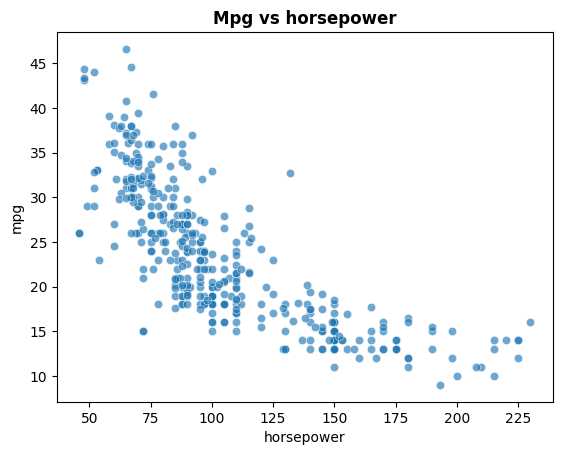

In [37]:
fig, ax = plt.subplots();
sns.scatterplot(data=auto, x='horsepower', y='mpg', alpha=.65, ax=ax);
ax.set_title('Mpg vs horsepower', weight = 'bold');

We see that as the horsepower of the vehicle increases, miles per gallon decreases. This makes sense as the more powerful the vehicle is, the more fuel it usually needs and as such the less `miles per gallon` we can drive. Without further ado, let's get into the modelling part!

### Inspecting different approaches of splitting data

---

> The validation set approach

Our goal is to split the dataset in two: `train`, `validate`. On the `train` we estimate the model's parameters and on the `validate` we see how the model performs on the unseen data. I will use `sklearn` method to create the two samples:

In [38]:
train, val = train_test_split(auto, test_size=196/392, random_state=11)

Next, we fit `simple` a linear regression model on the training set: `mpg`$= \beta_0 + \beta_1$ `horsepower` $+\epsilon$.

In [39]:
lm1 = smf.ols("mpg ~ horsepower", data=train)
r1 = lm1.fit()

To evaluate our model's performance on unseen data, we compute the `MSE`:

In [40]:
p1 = r1.get_prediction(val)
mse_val1 = sme.mse(p1.predicted_mean, val['mpg'])
print("MSE for LM1\n---\n{:.3f}".format(mse_val1))

MSE for LM1
---
24.005


Let's also get some visual idea how our model worked:


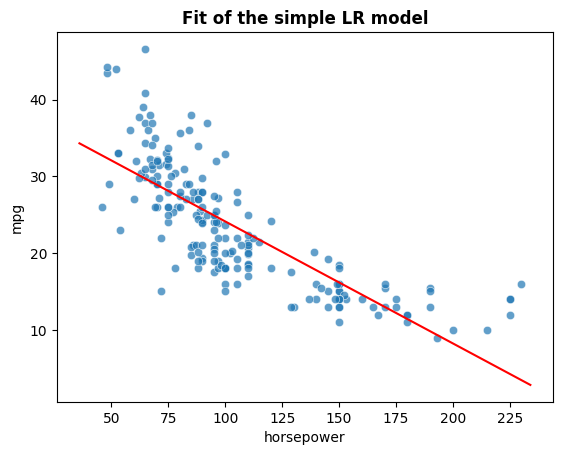

In [41]:
fig, ax = plt.subplots();

# Validation data
sns.scatterplot(data=val, x='horsepower', y='mpg', ax=ax, alpha=.70);

# Fitted line
p = r1.params
x = np.arange(val['horsepower'].min() - 10, val['horsepower'].max() + 5)
ax.plot(x, p.Intercept + p.horsepower * x, color='r');

# Description
ax.set_title("Fit of the simple LR model", weight='bold');

This does not look as the most optimal fit, this is also confirmed by the model's summary:

In [42]:
r1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     284.9
Date:                Tue, 12 Sep 2023   Prob (F-statistic):           6.35e-40
Time:                        12:47:39   Log-Likelihood:                -589.10
No. Observations:                 196   AIC:                             1182.
Df Residuals:                     194   BIC:                             1189.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     40.0231      1.047     38.241      0.000      37.959      42.087
horsepower    -0.1590      0.009    -16.879      0.000      -0.178      -0.140
==============================================================================
Omnibus:                        6.178   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                6.077
Skew:                           0.430   Prob(JB):                       0.0479
Kurtosis:                       3.059   Cond. No.                         331.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the summary we can read:

- `R-squared ~ 0.595` - meaning **horsepower** can only explain roughly 60 % of the variation in the **mpg**. We can do certainly better.

- `Prob (F-statistic)` - it is pretty much zero, therefore our model is certainly better than just `intercept` only model. This also implies that **horsepower** is actually good explanatory variable (this confirmed in the `OLS Regression results` section as well through `student test`)

With this being said, let's fit more complex models (complex in the features):

In [43]:
# Quadratic model
# -- Training
lm2 = smf.ols("mpg ~ horsepower + I(horsepower**2)", data=train)
r2 = lm2.fit()

# -- Prediction on validation
p2 = r2.get_prediction(val)
mse_val2 = sme.mse(p2.predicted_mean, val['mpg'])
print("MSE for LM2\n---\n{:.3f}".format(mse_val2))

MSE for LM2
---
18.633


In [44]:
r2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     196.8
Date:                Tue, 12 Sep 2023   Prob (F-statistic):           2.55e-47
Time:                        12:47:39   Log-Likelihood:                -568.70
No. Observations:                 196   AIC:                             1143.
Df Residuals:                     193   BIC:                             1153.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             56.9870      2.709     21.038      0.000      51.644      62.330
horsepower            -0.4693      0.047     -9.940      0.000      -0.562      -0.376
I(horsepower ** 2)     0.0013      0.000      6.683      0.000       0.001       0.002
==============================================================================
Omnibus:                        9.897   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               14.673
Skew:                           0.297   Prob(JB):                     0.000651
Kurtosis:                       4.202   Cond. No.                     1.32e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

`R-squared` improved, also based on `AIC` and `MSE` we are doing better. As we can also tell by `student test` (or `t-test`), the newly added feature is also important. We can also look at the plot and see that the new model seems to fit overall better:

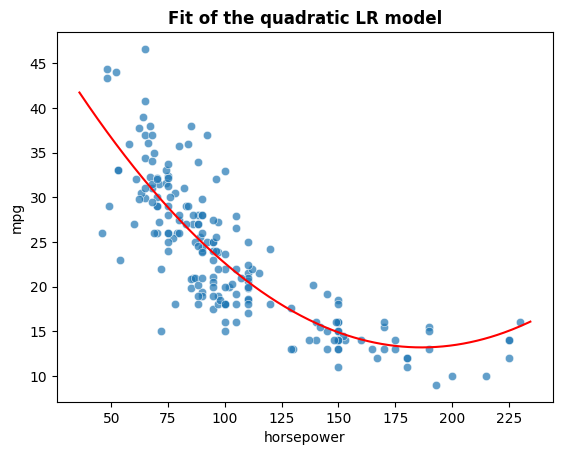

In [45]:
fig, ax = plt.subplots();

# Validation data
sns.scatterplot(data=val, x='horsepower', y='mpg', ax=ax, alpha=.70);

# Fitted line
p = r2.params
x = np.arange(val['horsepower'].min() - 10, val['horsepower'].max() + 5, .5)
ax.plot(x, p.Intercept + p.horsepower * x + p['I(horsepower ** 2)']*x**2, color='r');

# Description
ax.set_title("Fit of the quadratic LR model", weight='bold');

Let's see if things improve even more if we try `cubic model`:

In [46]:
# Cubic model
# -- Training
lm3 = smf.ols("mpg ~ horsepower + I(horsepower**2) + I(horsepower**3)", data=train)
r3 = lm3.fit()

# -- Prediction on validation
p3 = r3.get_prediction(val)
mse_val3 = sme.mse(p3.predicted_mean, val['mpg'])
print("MSE for LM3\n---\n{:.3f}".format(mse_val3))

MSE for LM3
---
18.691


In [47]:
r3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     131.6
Date:                Tue, 12 Sep 2023   Prob (F-statistic):           2.39e-46
Time:                        12:47:39   Log-Likelihood:                -568.16
No. Observations:                 196   AIC:                             1144.
Df Residuals:                     192   BIC:                             1157.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             63.8674      7.212      8.855      0.000      49.642      78.093
horsepower            -0.6569      0.188     -3.490      0.001      -1.028      -0.286
I(horsepower ** 2)     0.0028      0.002      1.843      0.067      -0.000       0.006
I(horsepower ** 3) -4.014e-06    3.9e-06     -1.029      0.305   -1.17e-05    3.68e-06
==============================================================================
Omnibus:                       10.699   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               17.591
Skew:                           0.281   Prob(JB):                     0.000151
Kurtosis:                       4.356   Cond. No.                     5.81e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.81e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Quadratic model has the lowest `AIC` score, hence better

This time, we got only a slight improvement. Most importantly notice, `p-values` for `quadratic` and `cubic` features, it suggests we remove them given our threshold is `0.05`. Therefore, overall the `bias-variance` tradeoff is provided by the `quadratic` model.

Let's experiment more with how choice of the `seed` affects the mse we get for given model, we first need to get the sample data:

In [48]:
# Generate 1000 seeds
seeds = np.linspace(1, 1000, 1000)

# Collect mses for different seeds
mses = []
for s in seeds:

    # -- Training
    train, val = train_test_split(auto, test_size=196/392, random_state=int(s))
    lms = smf.ols("mpg ~ horsepower + I(horsepower**2)", data=train)
    rs = lms.fit()

    # -- Prediction on validation
    ps = rs.get_prediction(val)
    mse_vals = sme.mse(ps.predicted_mean, val['mpg'])
    mses.append(mse_vals)

Now, we can inspect the `distribution`:

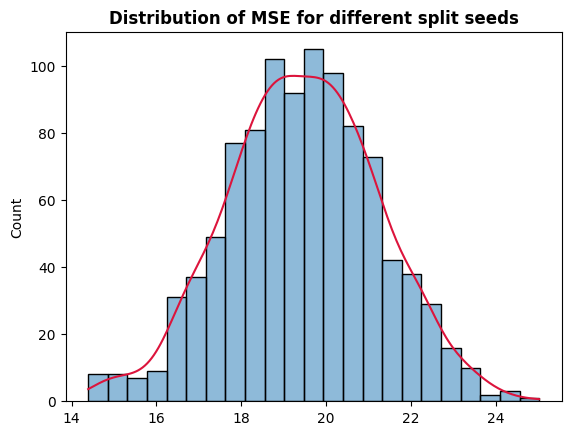

In [49]:
fig, ax = plt.subplots()
sns.histplot(x=mses, ax=ax, kde=True);
ax.set_title('Distribution of MSE for different split seeds', weight='bold');
ax.lines[0].set_color('crimson')

We can see that the `mean` lies somewhere around `20`, but with our initial attempt we got `18.633`, therefore we might be slightly more positive about our model's performance that what might be the reality. I think this demonstrates well why it is better to use `confidence intervals` rather than a single estimate. Let's compute 95 % confidence interval from the above distribution:

In [50]:
lower, upper = np.percentile(mses, [2.5, 97.5])
print("Lower: {:.3f}".format(lower))
print("Upper: {:.3f}".format(upper))

Lower: 15.961
Upper: 22.914


> Main takeaways from this section

In the first part of this section, we have fitted different `LR` models to model a non-linear relationship between `Miles per gallon` and vehicles's `horsepower`. As was obvious from the beginning, simple linear regression was not quite a good fit, both visually as well based on the metrics (`MSE`, `R-square`). Increasing the model's complexity to `quadratic`, we have seen a signifficant improvement which was supported by the given metrics. In addition, we could confirm through `t-test` that selected model's features were important in prediction the response variable. Finally, trying `cubic` model on the validation data resulted in insignifficant improvement that could also be simply due to a poor chance. Through `t-test` we have seen that quadratic feature is not important at all when it comes to explaining the `mpg`.


In the second part, we focused on how different splits of data affect the `MSE` we get from the validation dataset after we fit the given model. We got normally distributed `MSEs` centered around 20. This showed us that we might get very different `MSE` estimates based on different splits. As such, using single split of data to asses performance of the given model seems less robust. In the following section, we will discuss alternative approaches that improve on this shortcoming.

> k-fold cross validation and leave-one-out cross-validation

Just a quick recap, k-fold cross validation trains `k` separate models. Using picture from sklearn docs:

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" alt="Cross validation visualization from sklearn" width=80%>

The blue higlighted folds serve as `validation` data and green are `training` data. This way, we take into account several possible splits of the dataset instead of just one. Once we are satisfied with cross validation results, we evalute the best model on the `test` data. `Leave-one-out` cross validation is a specifal configuration of the `k-fold` cross validation where $$k = n$$, i.e., we train a model for each sample. Let's get into the implementation (each `docstring` explains what is going on):

In [51]:
def get_sizes(n, k):
    """Returns size for each split

    There are two cases to handle:
    1. n is divisible by k - all splits are equally sized
    2. else - compute the base size for all splits, add one to the first r splits where is the remainder
    after n % k = r

    Attributes
    ----------
    n : int
        Number of samples in data
    
    k : int
        Number of splits
    
    Returns
    -------
    sizes : 1d array
        Size for each split
    """

    remainder = n % k
    base_size = n // k
    sizes = np.empty(k)
    sizes.fill(base_size)
    if remainder != 0:
        sizes[:remainder] += 1

    return sizes

In [52]:
class CxValResults:
    """Holds results of the cross-validation

    Attributes
    ----------
    rks : list
        Statsmodel results object for kth fit
    yval_k : list of lists
        yhat and y for each kth split
    K : int
        Number of splits
    """
    def __init__(self):
        self.rks = []
        self.yval_k = []
        self.K = None
    
    def score(self, metric_name):
        """Produces requested score

        Attributes
        ----------
        metric_name : string
            Metric to compute
        """

        if metric_name == 'mse':
            mse_k = []
            for yval in self.yval_k:
                mse_k.append(sme.mse(yval[0], yval[1].predicted_mean))
            return mse_k, np.mean(mse_k)
        else:
            raise ValueError("Specified metric name does not exist")
    
    def summary(self):
        """Produces summary of the given cross-validation

        Todo
        ----
        Feel free to extend this as you like
        """
        _, mse_avg = results.score('mse')
        now = datetime.now()
        print("Overview\n---")
        print("Date and time: ", now.strftime("%m/%d/%Y, %H:%M:%S"))	
        print(f"K: {self.K}")
        print("Mean MSE: {:.3f}".format(mse_avg))

In [53]:
def cross_validate(model, definition, data, yname, k):

    """Cross validate given model

    Attributes
    ----------
    model : statsmodel.formula.api.[model_name]
        One of the statsmodel formula api models like 'ols'
    definition : string
        Formula definition of the given model
    data :  pd.DataFrame
        Input data to cross validate
    yname : string
        Name of the target variable
    k : int
        Number of splits

    Returns
    -------
    results : CxValResults
        Object that stores info about the cross validation process
    """
    
    # Get basic info about provided data
    n = data.shape[0]
    sizes = get_sizes(n, k)

    # Basic input validity check
    assert k <= n, f"K expected to be smaller or equal to N, got: {k}"
    

    # Get k datasets represented as indices
    idx = np.array([i for i in range(n)])
    is_not_selected = np.full(n, True)
    results = CxValResults()
    results.K = k

    for size in sizes:

        # Select sample ids for given split
        idx_sample = np.random.choice(idx[is_not_selected], int(size), replace=False)

        # Updated is_not_selected
        selected = np.isin(idx, idx_sample)
        is_not_selected = np.logical_and(is_not_selected, ~selected)

        # Select the actual data
        train = data[~selected]
        val = data[selected]

        # Fit it
        mk = model(definition, data=train)
        rk = mk.fit()

        # Save output to the results
        results.rks.append(rk)

        # Make prediction on validation
        results.yval_k.append([val[yname], rk.get_prediction(val)])
    
    return results

Below, you can test it out with any `K` as long as $$K <= N$$:

In [54]:
K = 196
results = cross_validate(smf.ols, "mpg ~ horsepower", train, 'mpg', K)
results.summary()

Overview
---
Date and time:  09/12/2023, 12:47:50
K: 196
Mean MSE: 24.582


Note that there is **no right way** how to do the implementation as long it meets the basic requirements of randomizing splits and making them even. In addition, make sure that you train on the right part of the data. Next, let's try to make our model more complex using `polynomial terms`. Since I am using `statsmodels formula api`, I will define a function that will generate model formula for us first (assuming we have just one feature and one response variable):

In [55]:
def get_formula(degree, x, y):

    formula = f"{y} ~ {x}"
    if degree == 0:
        raise ValueError("Degree must be at least 1!")
    elif degree == 1:
        return formula
    else:
        for i in range(2, degree + 1):
            formula += f" + I({x}**{i})"
        return formula

Let's verify it works correctly:

In [56]:
get_formula(3, 'horsepower', 'mpg')

'mpg ~ horsepower + I(horsepower**2) + I(horsepower**3)'

Now, let's see how `cross-validated MSE` varies as we change the `degree` of the polynomial, we first compute the `mses`:

In [57]:
min_degree = 1
max_degree = 20
K = 10

mses = []
for d in range(min_degree, max_degree+1):
    definition = get_formula(d, 'horsepower', 'mpg')
    ri = cross_validate(smf.ols, definition, train, 'mpg', K)
    _, mse = ri.score('mse')
    mses.append(mse)

And now we can plot them against the corresponding degree:

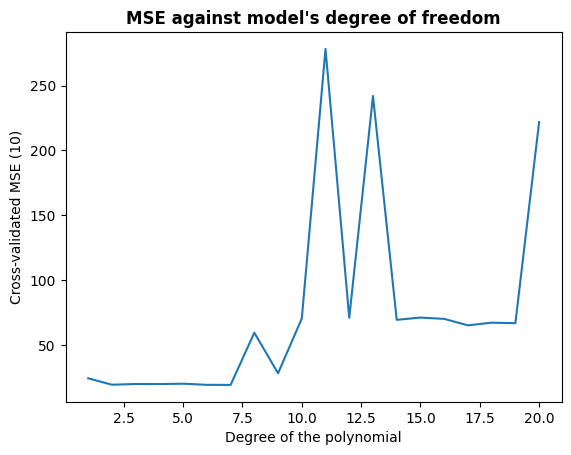

In [58]:
fig, ax = plt.subplots()

sns.lineplot(x=np.arange(min_degree, max_degree+1, 1), y=mses, ax=ax);
ax.set_xlabel("Degree of the polynomial");
ax.set_ylabel(f"Cross-validated MSE ({K})")
ax.set_title("MSE against model's degree of freedom", weight='bold');

This is not surprising since as we increase the model's complexity, it is able to fit the given `training data` perfectly (`low bias`), but then on validation data, it performs poorly (`high variance`). In fact, if we have `n` datapoints, then we can fit it perfectly with polynomil of degree `n-1`. (Recall first lecture in `LAO`)

> Main takeaways from this section

This section focused on the different ways we can split the data and as such train and evaluate our model. Namely: **simple train, val, test split**, **k-fold cross-validation**. As a rule of thumb, it is better to use cross validation so your research results are more robust. Of course this comes at the computational cost, however on modern multi-core machines process such as cross validation can be easily parallelized. In fact, if you show me working code how you parallelized the cross-validation, I buy a beer in Scroll bar ;)

Finally, we demonstrated what it means in practice the `bias-variance` tradeoff through using different `polynomials`.

### Shrinkage/Regularization

---

In this last section of the notebook, we will focus on examining effects of `reguralization` using two `Ridge` and `Lasso regression`. To do that, I will use `sklearn` as I have been using `statsmodels` for the previous sections. Therefore, let's first get our `train-test` splits:

In [59]:
# Split into X and y
colmask = (auto.columns != 'mpg') & (auto.columns != 'name')
X = auto.loc[:, colmask]
y = auto['mpg']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

We can not forget on data standardisation since they are of different scales:

In [60]:
transformer = StandardScaler()
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

Next, we compute cross-validated `mses` for each `alpha` (the larger, the stronger we regulate):

In [61]:
# Set basic parameters
alphas = np.arange(1e-4, 10, 0.5)
K = 5

# Compute cross-validated mses
ridge_mses = []
lasso_mses = []

for alpha in alphas:
    # Ridge
    ridge = Ridge(alpha)
    scores = cross_val_score(ridge, X_train, y_train, cv=K, scoring='neg_mean_squared_error')
    ridge_mses.append(-1*np.mean(scores))

    # Lasso
    lasso = Lasso(alpha)
    scores = cross_val_score(lasso, X_train, y_train, cv=K, scoring='neg_mean_squared_error')
    lasso_mses.append(-1*np.mean(scores))

Finally, let's examine how `mses` change as we increase `reguralisation`:

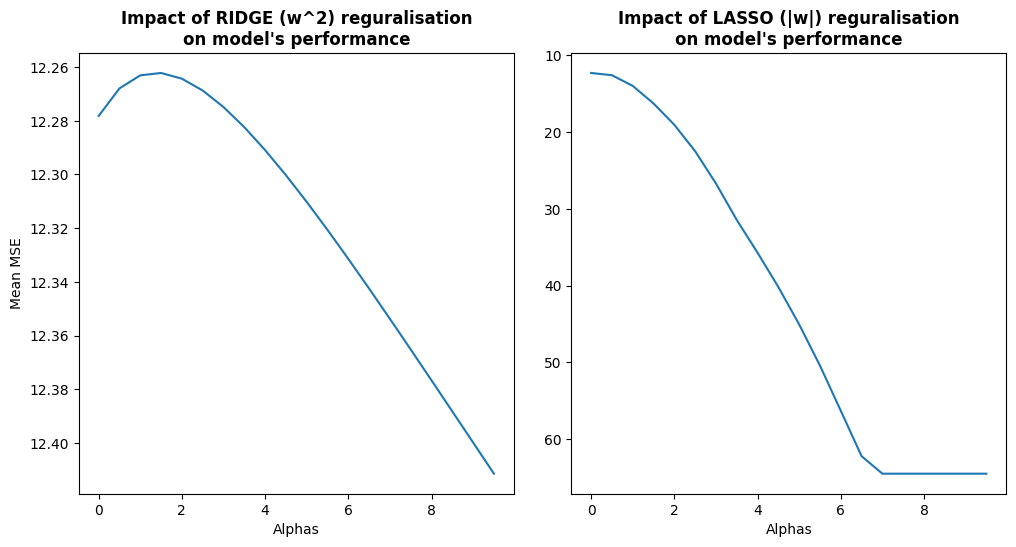

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5));
plt.tight_layout();

# Ridge
ax[0].plot(alphas, ridge_mses);
ax[0].set_xlabel("Alphas");
ax[0].set_ylabel("Mean MSE");
ax[0].set_title("Impact of RIDGE (w^2) reguralisation\non model's performance", weight='bold');
ax[0].set_ylim(ax[0].get_ylim()[::-1]);


# Lasso
ax[1].plot(alphas, lasso_mses);
ax[1].set_xlabel("Alphas");
ax[1].set_title("Impact of LASSO (|w|) reguralisation\non model's performance", weight='bold');
ax[1].set_ylim(ax[1].get_ylim()[::-1]);

First, we see that as we `reguralize more`, the model's performance on unseen validation data (`MSE`) decreases (i.e. MSE is larger - note that I have inverted axis to make it more intuitive). Second, `Ridge` regression decreases the `MSE` faster compare to the `LASSO` which makes sense given the way they transform model's parameters  (square vs absolute value). From these graphs, we can conclude that best `alpha` for:

- `Ridge` is 1
- `Lasso` is 1e-4

Let's fit both of these models on the whole training data with these hyper-parameters and inspect their parameters:

In [63]:
ridge = Ridge(1).fit(X_train, y_train)
ridge.coef_

array([-0.61921436,  1.31687369, -0.86093072, -4.89752842,  0.05826908,
        2.75703897,  1.31019412])

In [64]:
lasso = Lasso(1e-4).fit(X_train, y_train)
lasso.coef_

array([-0.68417413,  1.5668059 , -0.82758064, -5.08690174,  0.09552955,
        2.77953525,  1.32346925])

Interestingly, we would expect `Lasso` model to be more sparse in terms of parameters (more zeros), but note that the alpha is set super low, if we try it with higher alpha, we get sparse parameter vector. (Try it) Let's now evaluate it on the test data:

In [65]:
yhat_ridge = ridge.predict(X_test)
mse_ridge_final = mean_squared_error(y_test, yhat_ridge)

yhat_lasso = lasso.predict(X_test)
mse_lasso_final = mean_squared_error(y_test, yhat_lasso)

print("Ridge model final performance (MSE) {:.3f}".format(mse_ridge_final))
print("Lasso model final performance (MSE) {:.3f}".format(mse_lasso_final))

Ridge model final performance (MSE) 10.206
Lasso model final performance (MSE) 10.143


`MSE` around `10` corresponds to the `cross-validated` mses (look at the figure above), therefore we can conclude saying that by using cross-validation and reguralization we got to well-generalizing model :)

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=95bc4be7-be5d-4c7a-aee2-7f04cd4dbee4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>